# Project - Clustering country by SDG indicators

Importing libraries to **Google Colab**



In [1]:
import pandas as pd
from google.colab import drive
import numpy as np
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

Creating supporting variables


In [3]:
lista_dev = ['Austria',
'Belgium',
'Denmark',
'Finland',
'France',
'Germany',
'Greece',
'Ireland',
'Italy',
'Luxembourg',
'Netherlands',
'Portugal',
'Spain',
'Sweden',
'United Kingdom',
'Bulgaria',
'Croatia',
'Cyprus',
'Czech Republic',
'Estonia',
'Hungary',
'Latvia',
'Lithuania',
'Malta',
'Poland',
'Romania',
'Slovakia',
'Slovenia',
'Iceland',
'Norway',
'Switzerland',
'Australia',
'Canada',
'Japan',
'New Zealand',
'United States']
america_latina = [ "Mexico","Guatemala", "Honduras", "El Salvador", "Nicaragua", "Costa Rica", "Panama", "Colombia", "Venezuela", "Ecuador", "Peru", "Bolivia", "Chile", "Paraguay", "Brazil", "Argentina", "Uruguay", "Cuba", "Dominican Republic", "Haiti"]

In [4]:
Ks = np.arange(2, 20, 1) # Lista que registra os números de grupo (k) que serão avaliados
n_variance_range = np.arange(1, 100, 1)
years = [2016, 2017,2018]

Loading dataset

In [5]:
data ={}
for y in years:
  for tipo in ['ods']:
    df = pd.read_csv('/content/drive/My Drive/Projeto Mega Blaster/E4_Guilherme_Souza/Dataset/final/'+str(y)+'/beta_dados_ODSs_'+tipo)
    df.drop('Unnamed: 0',axis=1,inplace=True)
    data[y] = df.copy()

Preparing learning settings

In [6]:
preprocessing = Pipeline(steps=[('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),('scaler', MinMaxScaler())])

In [7]:
def run_save(dados1, y, k):
  X=dados1

  km = KMeans(n_clusters=k, random_state=0)
  km.fit_transform(X)
  
  elb = km.inertia_

  # Medindo a qualidade na classificação através no número de Silhouette
  sil = silhouette_score(X, km.predict(X))

  return (sil, elb)

## Evaluating hiperparameters

### Training models and saving results in a csv file

In [8]:
# data_PCA = {}
# dataF = {}
# sil = {}
# train = {}
# elbow_k, elbow_init = {}, {}
# df = {}
# i=0
# for y in data:
#   print(y)
#   dataF[y]=pd.DataFrame({'comp_num':[], 'var_ratio':[], 'k':[], 'inertia':[], 'sil':[]})      
#   for n in n_variance_range:
#     X = preprocessing.fit_transform(data[y].drop(['pais'],axis=1))
#     pca = PCA(n_components=n)

#     principalComponents = pca.fit_transform(X)

#     # principalDf = pd.DataFrame(data = principalComponents.transform(X),columns =[y[1]+ str(i) for i in np.arange(0,len(pca.explained_variance_ratio_))]).copy()
#     # print(pca.explained_variance_ratio_)

#     # principalDf['pais'] = data[y]['pais']

#     # data_PCA[y]=principalDf.copy()
#     # elbow_k[y] = []
#     # elbow_init[y] = {'ods':[]}

#     # df1= data_final[y].drop(columns = "pais")
#     # print(principalComponents)
#     variance_pca = pd.DataFrame()
#     store = 0
#     for v in pca.explained_variance_ratio_:
#       store+=v

#     for k in Ks:
#       (sil, ini) = run_save(principalComponents, y, k)

#       dataF[y].loc[i] = {'comp_num':n, 'var_ratio':store, 'k':k, 'inertia':ini, 'sil':sil}
#       i+=1

In [9]:
# for y in dataF:
#   dataF[y].to_csv('/content/drive/MyDrive/Projeto Mega Blaster/E4_Guilherme_Souza/Dataset/Training/'+str(y)+'-training-params')

### Load results created previously

In [10]:
dataF = {}
for y in years:
  dataF[y] = pd.read_csv('/content/drive/MyDrive/Projeto Mega Blaster/E4_Guilherme_Souza/Dataset/Training/'+str(y)+'-training-params')

### Hiperparams optimization

It was created a new cost function _F_ that receaves the silhouette coefiecient and the variance ratio of PCA decomposition. The choosen parameters for each year are the ones which mimimaze the cost function.

In [11]:
F = lambda df,v, s, k: ((df['var_ratio']-v)/v)**2 + 2*((df['sil']-s)/s)**2

In [12]:
for y in years:
  max_var = dataF[y]['var_ratio'].max()
  max_sil = dataF[y]['sil'].max()
  max_k = dataF[y]['k'].max()
  dataF[y]['F'] = F(dataF[y], max_var, max_sil, max_k)

In [13]:
otm_params = {}
for y in years:
  min_F = dataF[y]['F'].min()
  opt = dataF[y][dataF[y]['F']==min_F].copy()
  otm_params[y] = {'k':opt.k.values[0], 'n_comp': opt.comp_num.values[0] }
  print(f'Em {y} o número de grupos ótimo foi {str(opt.k.values[0])} usando {str(opt.comp_num.values[0])} componentes, com silhouette {str(opt.sil.values[0])}')

Em 2016 o número de grupos ótimo foi 11.0 usando 4.0 componentes, com silhouette 0.5486519369275572
Em 2017 o número de grupos ótimo foi 13.0 usando 4.0 componentes, com silhouette 0.5487477890004475
Em 2018 o número de grupos ótimo foi 11.0 usando 4.0 componentes, com silhouette 0.5394486131544094


In [14]:
otm_params

{2016: {'k': 11.0, 'n_comp': 4.0},
 2017: {'k': 13.0, 'n_comp': 4.0},
 2018: {'k': 11.0, 'n_comp': 4.0}}

Plotting F values for each parameters

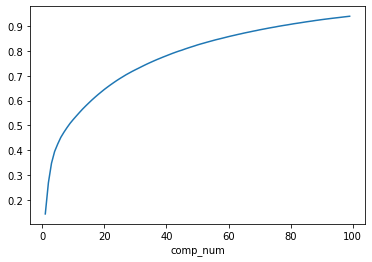

In [15]:
dataF[2016][dataF[2016]['k']==11].groupby('comp_num').mean()['var_ratio'].plot()

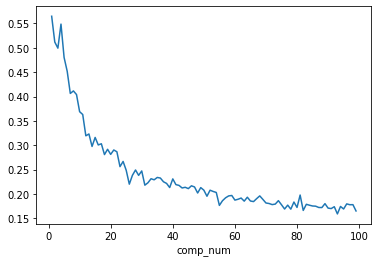

In [16]:
dataF[2016][dataF[2016]['k']==11].groupby('comp_num').mean()['sil'].plot()

## Training final models




In [17]:
df = {}
pca = {}
for y in years:
  X = preprocessing.fit_transform(data[y].drop(['pais'],axis=1))

  pca[y] = PCA(n_components=int(otm_params[y]['n_comp']))
  k_means = KMeans(n_clusters=int(otm_params[y]['k']), random_state=0)

  principalComponents = pca[y].fit_transform(X)
  k_means.fit_transform(principalComponents)

  principalDf = pd.DataFrame(data = principalComponents,columns =['ind-0'+ str(i) for i in np.arange(0,len(pca[y].explained_variance_ratio_))]).copy()
  principalDf['grupo'] = k_means.predict(principalComponents)
  principalDf['pais'] = data[y]['pais']

  df[y] = principalDf.copy()
  df[y].to_csv('/content/drive/MyDrive/Projeto Mega Blaster/E4_Guilherme_Souza/Dataset/v02_training/teste/cluster_'+str(y)+'.csv', index=False)

## Evaluating results

### Plotting the clusters distribution

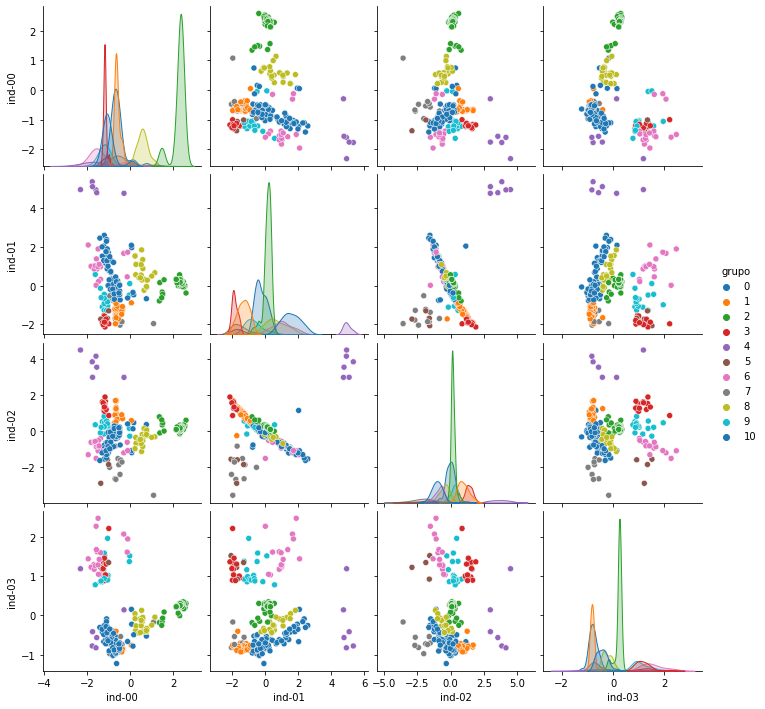

In [18]:
import seaborn as sns

sns.pairplot(
    data=df[2016],
     hue="grupo", palette="tab10",
)

In [19]:
df[2016].groupby('grupo').count()

,ind-00,ind-01,ind-02,ind-03,pais
grupo,,,,,
0,28,28,28,28,28
1,29,29,29,29,29
2,61,61,61,61,61
3,16,16,16,16,16
4,6,6,6,6,6
5,4,4,4,4,4
6,17,17,17,17,17
7,10,10,10,10,10
8,21,21,21,21,21


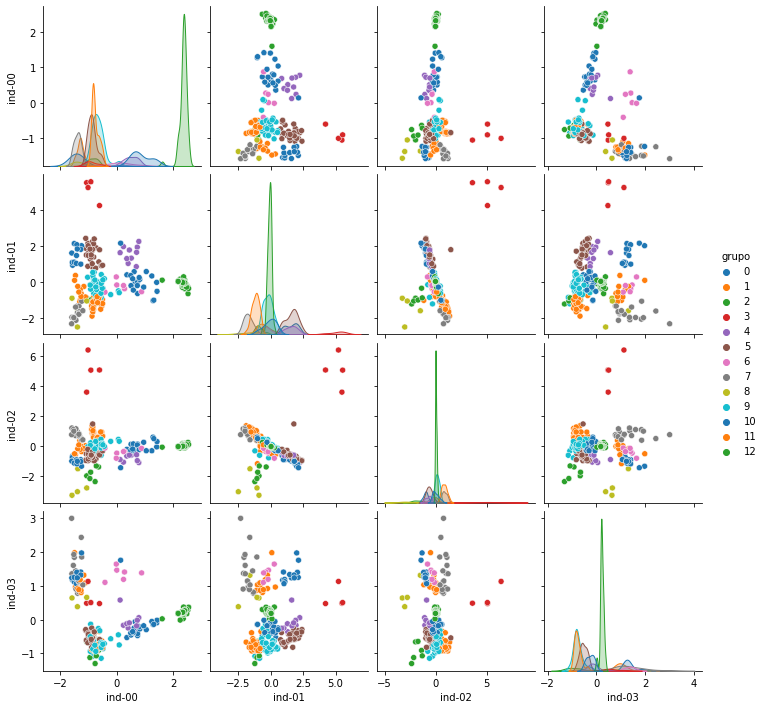

In [20]:
sns.pairplot(
    data=df[2017],
     hue="grupo", palette="tab10",
)

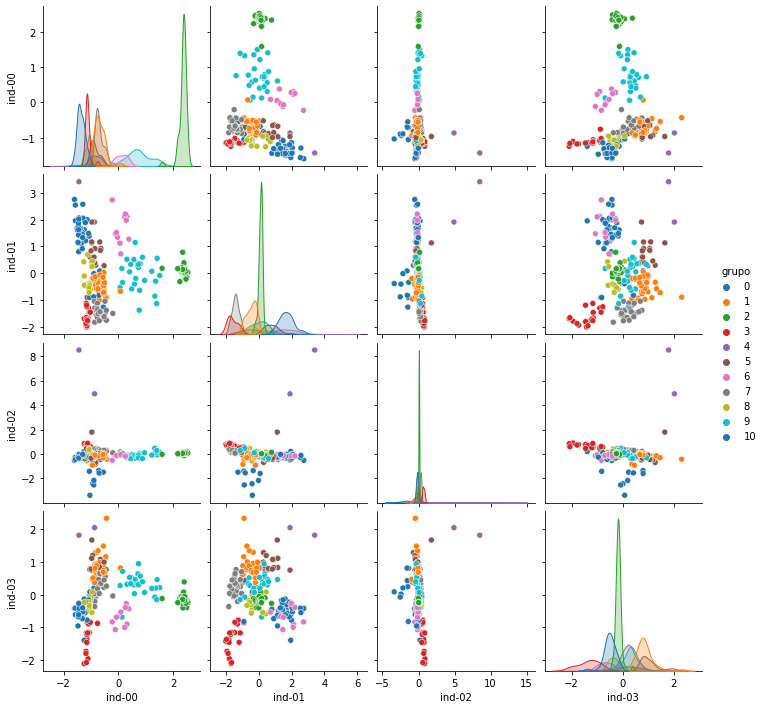

In [21]:
sns.pairplot(
    data=df[2018],
     hue="grupo", palette="tab10",
)

### Heatmap of the weigihts of each SDG on each component

In [23]:
def ind_p_ods(y):
  X = {o: [] for o in np.arange(1,18,1)}
  for ind in data[y].columns:
    ods = ind.split('.')
    try:
      X[int(ods[0])].append(ind)
    except:
      continue
  return X

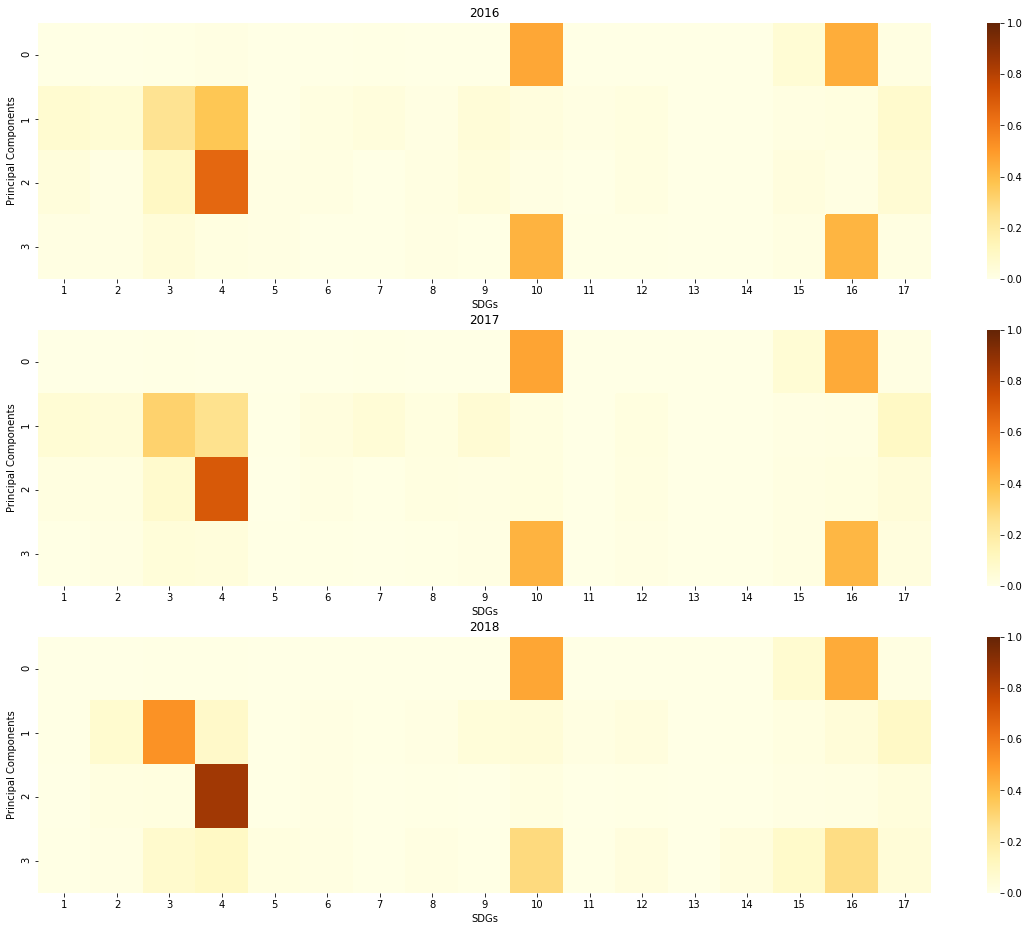

In [36]:
fig,ax = plt.subplots(3, 1,figsize=(20,16))

weights_df = {}
i=0
for y in years:
  pca[y].components_
  ndata = data[y].drop('pais',axis=1)

  weights_df[y] = pd.DataFrame(pca[y].components_**2, columns= ndata.columns)

  ipo = ind_p_ods(y)

  ods = pd.DataFrame()
  for o in ipo:
    ods[o] = weights_df[y][ipo[o]].sum(axis=1)

  sns.heatmap(ods, cmap='YlOrBr'
    ,ax=ax[i]
    , vmin=0, vmax=1
    )
  ax[i].set_title(y)
  ax[i].set_xlabel("SDGs")
  ax[i].set_ylabel("Principal Components")
  i+=1
plt.show()